In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
cjs = pd.read_pickle('mgiseq/tables/cannonical-jumps-fully-annotated.pickle')

In [3]:
cjs.head()

,name,jumpfrom,jumpto,count,startpos,productsize,sneek,translation,annot_cds,annot_cds_start,annot_cds_end,startmatch_name,startmatch_offset,stopmatch_name,stopmatch_offset
0,j1,64,28254,7012631,28273,419,gtagatctgttcTCTAAACGAACA,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,N,28273.0,29533.0,N,0.0,N,0.0
1,j2,65,21551,1117576,21562,1273,tagatctgttctCTAAACGAACAA,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,S,21562.0,25384.0,S,0.0,S,0.0
2,j4,66,27384,688112,27393,121,agatctgttctcTAAACGAACATG,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...,ORF7a,27393.0,27759.0,ORF7a,0.0,ORF7a,0.0
3,j5,65,25380,618367,25392,275,tagatctgttctATAAACGAACTT,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,ORF3a,25392.0,26220.0,ORF3a,0.0,ORF3a,0.0
4,j6,65,27883,229749,27893,121,tagatctgttctCTAAACGAACAT,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...,ORF8,27893.0,28259.0,ORF8,0.0,ORF8,0.0


In [4]:
orfcolors = pd.read_csv('colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [5]:
grouped = (
    cjs.groupby('startpos').agg({
        'count': 'sum',
        'productsize': 'first',
        'translation': 'first',
        'annot_cds': 'first',
        'startmatch_name': 'first',
        'startmatch_offset': 'first',
    })).sort_values(by='count', ascending=False)
grouped

,count,productsize,translation,annot_cds,startmatch_name,startmatch_offset
startpos,,,,,,
28273,7084923,419,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,N,N,0.0
21562,1139766,1273,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,S,S,0.0
27393,700608,121,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...,ORF7a,ORF7a,0.0
25392,618902,275,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,ORF3a,ORF3a,0.0
27893,233648,121,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...,ORF8,ORF8,0.0
...,...,...,...,...,...,...
14890,1,14,MVAVLMLTKSSSTT,NaN,pp1ab,14625.0
14963,1,2,MG,NaN,pp1ab,14698.0
15490,1,58,MPQLLMLIVFLTFVKLSRPMLMHFYLLMVTKLPISMSAIYNTDFMS...,NaN,pp1ab,15225.0


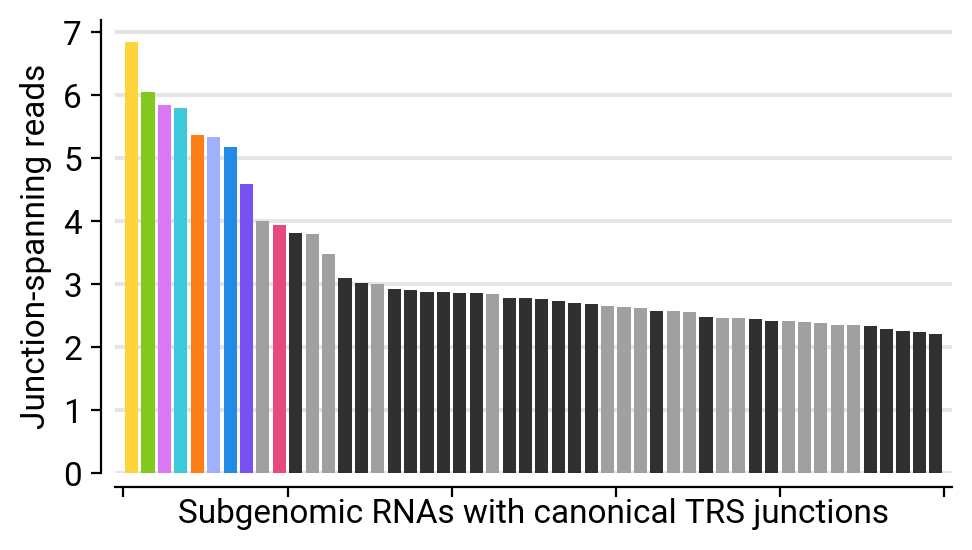

In [6]:
PLOTFIRSTN = 50
COLOR_TRUNCATION = '#a0a0a0'
COLOR_FRAMESHIFT = '#303030'

def get_color(row):
    if row['annot_cds'] in orfcolors:
        return orfcolors[row['annot_cds']]
    if row['startmatch_offset'] % 3 == 0:
        return COLOR_TRUNCATION
    else:
        return COLOR_FRAMESHIFT
        

groups = grouped.iloc[:PLOTFIRSTN].copy()
groups['facecolor'] = groups.apply(get_color, axis=1)
groups['x'] = np.arange(PLOTFIRSTN) + .5

fig, ax = plt.subplots(1, 1, figsize=(5.4, 3))

for color, bars in groups.groupby('facecolor'):
    ax.bar(bars['x'].tolist(), np.log10(bars['count']).tolist(),
           facecolor=color, width=.8, zorder=3)

for sp in 'top right'.split():
    ax.spines[sp].set_visible(False)

ax.set_xlabel('Subgenomic RNAs with canonical TRS junctions')
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel('Junction-spanning reads')
ax.set_yticks(np.arange(0, 8))
for i in range(0, 8):
    ax.axhline(i, c='black', alpha=.1, zorder=1)

ax.set_xlim(-.5, PLOTFIRSTN + .5)
plt.savefig('figure-outputs/plot-canonical-trs-products.pdf')

In [7]:
grouped.head(20)

,count,productsize,translation,annot_cds,startmatch_name,startmatch_offset
startpos,,,,,,
28273,7084923,419,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,N,N,0.0
21562,1139766,1273,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,S,S,0.0
27393,700608,121,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...,ORF7a,ORF7a,0.0
25392,618902,275,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,ORF3a,ORF3a,0.0
27893,233648,121,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...,ORF8,ORF8,0.0
26522,219080,222,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...,M,M,0.0
26244,150031,75,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,E,E,0.0
27201,38914,61,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...,ORF6,ORF6,0.0
27824,9864,20,MLIIFWFSLELQDHNETCHA,NaN,ORF7b,69.0
